In [1]:
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sn
%matplotlib inline
import numpy as np
from wordcloud import WordCloud
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from IPython.display import display, HTML
import networkx as nx
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
import itertools
import gensim
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [2]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

### The following questions/techniques will be addressed in this project:

1. What are the most commonly used ingredients?
2. How can we represent "dishes" as a network of ingredients ? 
3. How can we cluster "dishes" in terms of their recipe components? (Use PCA and t-SNE)
4. Recommend recipes based on ingredients

## Load & Preprocess Data

In [3]:
ingredients_df = pd.read_csv("Data/annotations/cleaned_ingredients.txt", 
                             sep=" ", 
                             header=None, 
                             names=["ingredients"],
                             index_col=False)

recipes_df = pd.read_csv("Data/annotations/cleaned_classes.txt", 
                         header=None, 
                         names=["recipe_name"],
                         index_col=False)

dish_recipe_mapping = pd.read_csv("Data/annotations/dish_recipes_mapping",
                                  header=None, 
                                  names=["dish"],
                                  index_col=False)

dishes_df = pd.DataFrame(dish_recipe_mapping.dish.str.split('/',1).str[0])\
            .drop_duplicates(["dish"]).reset_index(drop=True)

ingredients_df.reset_index(drop=True, inplace=True)
recipes_df.reset_index(drop=True, inplace=True)

In [4]:
recipes_df.head()

,recipe_name
0,Einkorn Onion Rings
1,Crispy Onion Rings
2,Onion Rings
3,Onion Rings_2
4,Onion Rings_3


In [5]:
ingredients_df.head()

,ingredients
0,"milk,coconut,flour,baking,bread,salt,onion,egg"
1,"cayenne,cornmeal,garlic,flour,oil,panko,salt,o..."
2,"flour,oil,bread,baking,onion,egg"
3,"onion,oil,cake"
4,"celery,nut,flour,ale,baking,onion,egg"


### Unique Recipe + Ingredients

In [6]:
food_df = pd.concat([recipes_df, ingredients_df], axis=1)
food_df.head()

,recipe_name,ingredients
0,Einkorn Onion Rings,"milk,coconut,flour,baking,bread,salt,onion,egg"
1,Crispy Onion Rings,"cayenne,cornmeal,garlic,flour,oil,panko,salt,o..."
2,Onion Rings,"flour,oil,bread,baking,onion,egg"
3,Onion Rings_2,"onion,oil,cake"
4,Onion Rings_3,"celery,nut,flour,ale,baking,onion,egg"


### Unique Dishes

In [7]:
print(dishes_df.shape)
dishes_df.head()

(101, 1)


,dish
0,apple_pie
1,croque_madame
2,paella
3,gyoza
4,crab_cakes


### Mapping Recipes to Dishes

In [8]:
def map_dishes_to_recipe(recipe):
    for dish in dishes_df.itertuples():
        if dish[1].replace("_"," ") in recipe.replace("_", " ").replace("-"," ").lower():
            return dish[1]

In [9]:
food_df["dish"] = food_df.recipe_name.apply(map_dishes_to_recipe)

In [10]:
food_df.shape

(4826, 3)

In [11]:
food_df.dropna(subset=["dish"], inplace=True)
food_df = food_df.reset_index(drop=True)
food_df.shape

(4330, 3)

In [12]:
food_df.isnull().sum()

recipe_name    0
ingredients    0
dish           0
dtype: int64

## Preprocessed Dataset for Food Analysis

In [13]:
food_df

,recipe_name,ingredients,dish
0,Einkorn Onion Rings,"milk,coconut,flour,baking,bread,salt,onion,egg",onion_rings
1,Crispy Onion Rings,"cayenne,cornmeal,garlic,flour,oil,panko,salt,o...",onion_rings
2,Onion Rings,"flour,oil,bread,baking,onion,egg",onion_rings
3,Onion Rings_2,"onion,oil,cake",onion_rings
4,Onion Rings_3,"celery,nut,flour,ale,baking,onion,egg",onion_rings
...,...,...,...
4325,Chocolate Ice Cream_21,"sugar,milk,whipping,water,chocolate,cocoa,egg",chocolate_ice_cream
4326,Dark Chocolate Ice Cream,"sugar,milk,dutch",chocolate_ice_cream
4327,The Darkest Chocolate Ice Cream,"sugar,milk,corn",chocolate_ice_cream
4328,Homemade Chocolate Ice Cream_4,"sugar,milk,brown",chocolate_ice_cream


## Frequency Distriution of Alternative Recipes by Dish

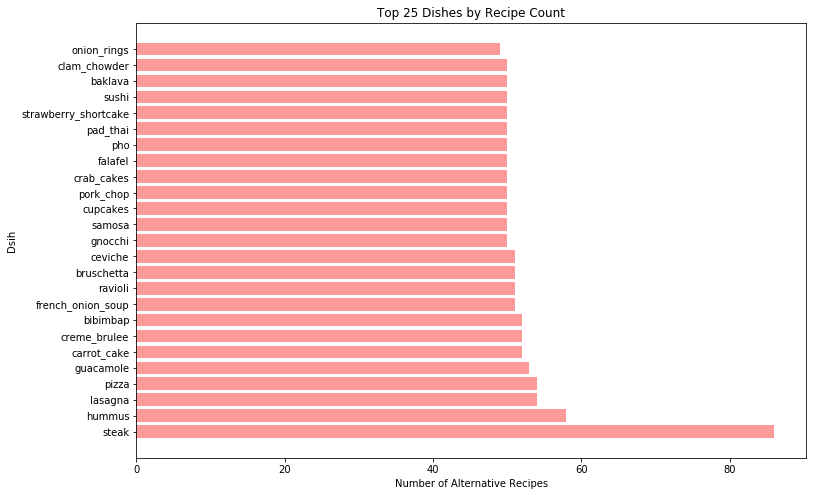

In [14]:
recipe_per_dish = food_df.groupby(["dish"])["recipe_name"].agg(["count"])\
            .sort_values(by = "count", ascending=False)\
            .rename(columns = {"count" : "recipe_count"}).iloc[: 25] 

plt.figure(figsize = (12, 8))
plt.barh(recipe_per_dish.index, recipe_per_dish.recipe_count, color = "#fb9a99")
plt.title("Top 25 Dishes by Recipe Count")
plt.ylabel("Dsih")
plt.xlabel("Number of Alternative Recipes")
plt.show()

## 1. What are the most commomly used ingredients?

In this section, we explore the most commonly used ingredients across recipes of all dishes.

In [15]:
def get_list_ingredients(df):
    possible_ingredients = {}

    def inc_dict(ing):
        if ing in possible_ingredients.keys():
            possible_ingredients[ing] += 1
            return
        possible_ingredients[ing] = 1
    
    type_ = int

    # Compute the frequency of ingredients in a data frame
    df["ingredients"].str.split(",").apply(lambda x: [inc_dict(ing) for ing in x])

    # Cast dict to list
    ing_data = np.array([[a[0], a[1]] for a in possible_ingredients.items()])    
    ing_data[:,1] = (ing_data[:,1].astype(type_))
    
    label = "Ingredient Frequency"
    df_ing = pd.DataFrame(data={"Ingredient": ing_data[:, 0], label: ing_data[:, 1].astype(int)})
    return df_ing

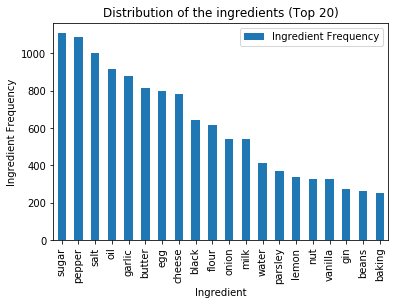

In [16]:
# Plot simple bar chart
ingredients = get_list_ingredients(food_df)
freqs = dict([tuple(x) for x in ingredients.values])

ax = ingredients.sort_values(by="Ingredient Frequency", ascending=False).head(20)\
        .plot(x="Ingredient", y="Ingredient Frequency", kind="bar")
ax.set_title("Distribution of the ingredients (Top 20)")
b = ax.set_ylabel("Ingredient Frequency")

We can clearly see that ingredients with **high prominence** are *sugar, pepper, salt, oil, garlic, butter, onion*. This is expected since they are "basic" ingredients used in almost any main dish across all dishes. Here "basic" we mean spices, herbs, oils and vegetables used for flavoring.

Yet, here is another cool representation of the frequency of ingredients:

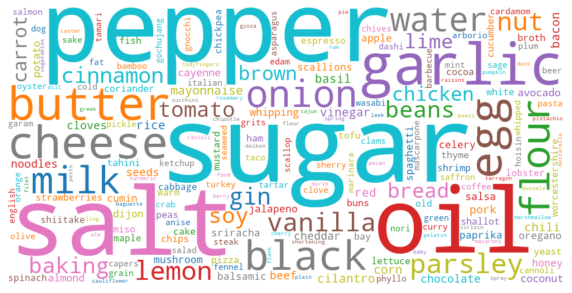

In [17]:
# Plot the word cloud of the most commonly used ingredients
fig = plt.figure(figsize = (10,10))
wc = WordCloud(background_color = "white", 
               colormap = "tab10", width = 1000, height = 500).generate_from_frequencies(freqs)
ax = plt.imshow(wc, interpolation="bilinear")
b = plt.axis("off")

## 2. How can we represent "dishes" as a network of ingredients ? 

Let's represent a recipe by a one hot encoded vector of its ingredients. To do so, we use **DictVectorizer** provided by scikit learn which establishes a vocabulary of ingredients and encodes each recipe in a **668-dimensional** vector of ingredients.

In [18]:
def convert_to_dict(arr):
    """ Helper function to convect an array of ingredients to a dictionary """
    d = {}
    for a in arr:
        d[a] = 1
    return d

# Shuffle the dataset for convinience
food_df = food_df.sample(frac=1).reset_index(drop=True)

# First we create a bag of words per recipe
food_df["bow"] = food_df.ingredients.str.split(",").apply(convert_to_dict)

print("Ingredients represented by Bag of Words for each Recipe")
print("\n")
print(food_df.bow)

# One hot encoding of the ingredients
vectorizer = DictVectorizer(sparse = False)
X = vectorizer.fit_transform(food_df.bow.tolist())
y = food_df.dish.astype("category").cat.codes

print("\n")
print("Shape of X and y after one hot encoding of the ingredients")
print("\n")
print(X.shape)
print(X)
print("\n")
print(y.shape)
print(y)

Ingredients represented by Bag of Words for each Recipe


0                   {'curry': 1, 'garlic': 1, 'black': 1}
1       {'sugar': 1, 'pumpkin': 1, 'cheese': 1, 'pie':...
2                {'cheese': 1, 'butter': 1, 'arborio': 1}
3       {'pepper': 1, 'cheese': 1, 'butter': 1, 'oil':...
4                             {'milk': 1, 'mccormick': 1}
                              ...                        
4325                                         {'black': 1}
4326        {'sugar': 1, 'egg': 1, 'milk': 1, 'brown': 1}
4327       {'sugar': 1, 'yeast': 1, 'milk': 1, 'warm': 1}
4328    {'sherry': 1, 'lobster': 1, 'celery': 1, 'garl...
4329    {'pepper': 1, 'cheese': 1, 'oregano': 1, 'kala...
Name: bow, Length: 4330, dtype: object


Shape of X and y after one hot encoding of the ingredients


(4330, 668)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


(4330,)
0       19
1       13
2 

In this section, we analyse combination of ingredients in dish recipes for a better description of a dish. Our approach consists in extracting the frequently used combination of ingredients that are typical to each dish.

First, we compute the pairwise appearance frequency between all ingredients in our dataset which will generate a N by N matrix (denoted by A) of frequencies(N is the number of ingredients). We then do the same operation for every dish.

In [19]:
# Building the first matrix of pairwise frequencies i.e. co-occurence matrix, (matrix A in explanation)
ing_net = X.T.dot(X)
np.fill_diagonal(ing_net, 0)
ing_net

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [20]:
def get_index_ingredient(ing, vectorizer):
    """Helper function to get the index of the ingredient given its name"""
    return np.argmax(vectorizer.transform([{ing:1}])[0])

In [21]:
def get_ing_name(idx, vectorizer):
    """Helper function to get the name of the ingredient given its index"""
    return vectorizer.feature_names_[idx]

In [22]:
def get_freq_net_dish(df, dish, tot_ing, vectorizer):
    """Computes the pairwise frequency between ingredients in a given dish"""
    list_ing = get_list_ingredients(df[df.dish == dish]).Ingredient
    X_one_hot_dish = vectorizer.transform(df[df.dish == dish].bow.values)
    dish_ing_net = np.zeros((tot_ing, tot_ing))
    # Iterate on the list of ingredients and compute their frequency
    for ing_name in list_ing:
        ing_id = get_index_ingredient(ing_name, vectorizer)
        freq_vec = X_one_hot_dish[X_one_hot_dish[:,ing_id] == 1].sum(axis = 0)
        # Frequency when it is paired with itself is removed for our convinience
        freq_vec[ing_id] = 0
        dish_ing_net[ing_id] = freq_vec
    return dish_ing_net

In [23]:
# Listing the dishes to be displayed in the graph
dishes = ["spaghetti_carbonara", "apple_pie", 
          "pizza", "nachos", "samosa", "ravioli", 
          "tiramisu", "steak",
          "chocolate_ice_cream","chocolate_cake"]

palette = ['#a6cee3','#1f78b4','#b2df8a','#33a02c',
           '#e31a1c','#fdbf6f','#ff7f00',
           '#f0fb99', '#99d2fb', '#e8edea']

# Build the graph where each node is an ingredient
# And edges link ingredients frequently used togheter in recipes
G = nx.Graph()
j = 0
for dish in dishes:
    # Get the pairwise frequency matrix and discount it
    dish_ing_net = get_freq_net_dish(food_df, dish, X.shape[1], vectorizer)
    dish_net_discounted = dish_ing_net/(ing_net+1)
    i = 0 # Add associated edges and nodes to the graph
    for raveled_id in np.argsort(-dish_net_discounted.reshape(-1)):
        a, b = np.unravel_index(raveled_id, dish_net_discounted.shape)
        # Take only a small number of ingredient for visual convinience
        if i > 10:
            break
        u, v = get_ing_name(a, vectorizer), get_ing_name(b, vectorizer)
        G.add_edge(u, v, dish = j, color = palette[j], weight = 1, width = dish_net_discounted[a,b])
        i += 1
    j += 1

In [24]:
# Source Code Reference: https://stackoverflow.com/questions/43541376/how-to-draw-communities-with-networkx

def community_layout(g, partition):
    """
    Compute the layout for a modular graph.
    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot
    partition -- dict mapping int node -> int community
        graph partitions
    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions
    """

    pos_communities = _position_communities(g, partition, scale=4.5)

    pos_nodes = _position_nodes(g, partition, scale=1.3)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos

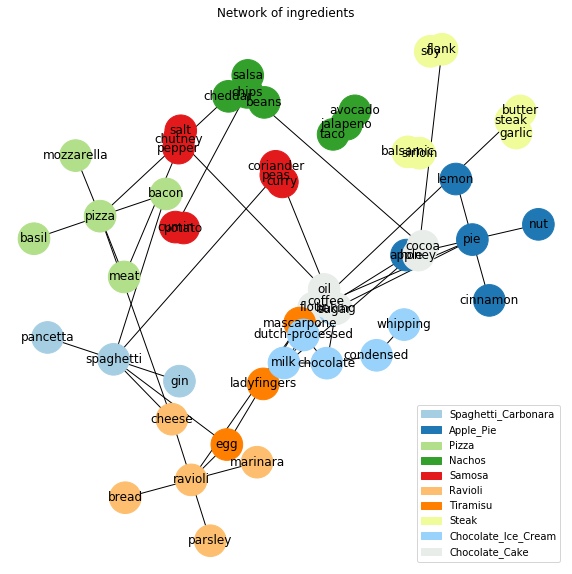

In [25]:
# Build a dictionary to associate each ingredient 
# to a cuisine where it appears the most
colors_nodes = []
partition = {}
for u in G.nodes():
    best_color = {}
    for v in G[u]:
        best_color[G[u][v]["color"]] = 1 if not G[u][v]["color"] in best_color else best_color[G[u][v]["color"]]+1
    partition[u] = sorted(best_color.items(), key=lambda x: x[1])[-1][0]
    
# Compute the x,y coordinates of the nodes
pos = community_layout(G, partition)

# Plot the graph (nodes and edges)
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G, pos, node_size = 1000, node_color = list(partition.values()))
nx.draw_networkx_edges(G, pos, edgelist = G.edges(), width = 1)
nx.draw_networkx_labels(G, pos, font_size = 12, font_family = "sans-serif")

# Plot the legend
patches = [mpatches.Patch(color=co, label=cu.title()) for co,cu in zip(palette,dishes)]
plt.legend(handles=patches, loc = "best", ncol=1)
plt.title("Network of ingredients")
b = plt.axis("off")

## How can we cluster "dishes" in terms of their recipe components? 

`Note:` **Using a subset of dish categories for demo purpose**

EDA Visualisations:- Clustering recipes by ingredients

In [19]:
list_dish_names = food_df.dish.astype("category").cat.categories


# Filter data and keep only n cuisines
filtered_dish = ["spaghetti_carbonara", 
                 "apple_pie", 
                 "pizza", 
                 "nachos", 
                 "samosa", 
                 "ravioli", 
                 "tiramisu", 
                 "baklava", 
                 "beef_salad", 
                 "hummus",
                 "chocolate_ice_cream", 
                 "chocolate_cake", 
                 "chocolate_mouse", 
                 "strawberry_shortcake", 
                 "sushi",
                 "dumplings",
                 "takoyaki",
                 "tuna_tartare",
                 "waffles"
                ]

mask = food_df.dish.apply(lambda x: x in filtered_dish)
X_filtered, y_filtered = X[mask], y[mask]

#### PCA: Principal component analysis

In this subsection, we compute the principal components of our dataset using the cosine kernel using the implementation of the PCA algorithm in scikit learn library

In [20]:
X_embedded_pca = KernelPCA(n_components = 2, kernel = "cosine", n_jobs = 2).fit_transform(X_filtered)
X_embedded_pca

array([[-0.22897729,  0.59516247],
       [-0.14774187, -0.08390727],
       [ 0.10262611, -0.09162828],
       ...,
       [ 0.3263921 , -0.08856548],
       [-0.40394725, -0.29009332],
       [-0.20055373, -0.15268077]])

Next, we plot the embedded results in a 2-dimensional graph:

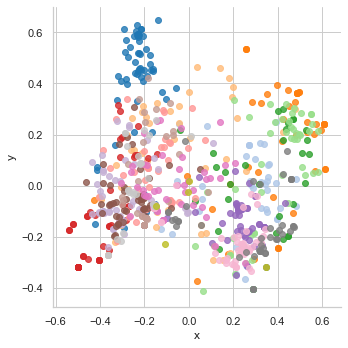

In [21]:
# Plotting the clusters
plotting_df = pd.DataFrame(data = X_embedded_pca[:,:2], columns = ["x","y"])
plotting_df["dish"] = list_dish_names[y_filtered].tolist()

sn.set(style = "whitegrid", palette = "muted")
sn.lmplot("x", "y", data = plotting_df, palette = "tab20", hue = "dish", fit_reg = False, legend=False)

#### t-SNE: t-distributed Stochastic Neighbor Embedding

In this subsection, we compute the t-distributed Stochastic Neighbor Embedding of our one hot encoded vectors using the cosine similarity with implementation of the t-SNE algorithm provided by the scikit learn library

In [22]:
# Compute the cosine similarity square form for each vector and run t-SNE
X_to_reduce = squareform(pdist(X_filtered, metric = "cosine"))
X_embedded_tsne = TSNE(metric = "precomputed", perplexity = 25).fit_transform(X_to_reduce)
X_embedded_tsne

array([[-33.32086  , -11.120993 ],
       [ -1.4638155,  13.483641 ],
       [ 17.987509 ,  12.966332 ],
       ...,
       [ 28.415392 ,  15.339793 ],
       [-21.959877 , -25.749432 ],
       [ -5.773227 ,  36.86966  ]], dtype=float32)

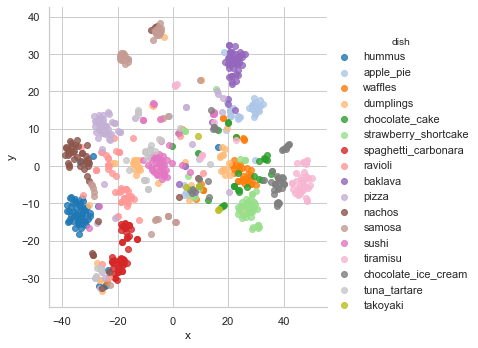

In [23]:
# Plotting the clusters on with t-sne projections
plotting_df = pd.DataFrame(data = X_embedded_tsne[:,:2], columns = ["x","y"])
plotting_df["dish"] = list_dish_names[y_filtered].tolist()

sn.set(style = "whitegrid", palette = "muted")
sn.lmplot("x", "y", data = plotting_df, palette = "tab20", hue = "dish", fit_reg = False)

As a first observation, t-SNE projection is much clearer than PCA: clusters are more visible and we have far better insights in comparision to KPCA.(e.g. Baklava, Tiramisu, Chocolate Cake and other desserts (dishes) are relatively close in both graphs, however more obvious with t-SNE)

## Recommend recipes based on similar ingredients

After the previous analysis, we saw how dishes are similar to each other in different aspects. A good problem to tackle would be to build a recommendation system for recipes. 

For a comparison purpose, we will approach this task using two different methodoligies. This will help us estimate their performance since there is no clear metric associated to the task.

**Cosine similarity with Doc2Vec vectors embedding**

Doc2Vec creates a vectorized representation of a document by taking into consideration their contexts. Our intuition is that it will help capture deeper relations between ingredients given the context in which they are used.

Next, we will compare 2 recipes vectors by cosine similarity using the Doc2Vec method which we hypothesize will give us more meaninful information than the simple comparision of the one hot encoded vectors.

In [19]:
class LabeledLineSentence(object):
    
    # Class that englobes the Doc2vec training data
    def __init__(self, doc_list, labels_list):
        self.labels_list = labels_list
        self.doc_list = doc_list
        rand_idx = np.random.permutation(list(range(len(self.labels_list))))        
        self.labels_list = np.array(self.labels_list)[rand_idx]
        self.doc_list = np.array(self.doc_list)[rand_idx]
        
    def __iter__(self):
        for idx, doc in enumerate(self.doc_list):
            yield gensim.models.doc2vec.LabeledSentence(words = doc.split(" "),tags = self.labels_list[idx])

In [20]:
def load_doc2vec_model(df):
    print("Training Doc2Vec model from scratch")
    
    # Contruct training data for the doc2vec model
    # doc_labels contain document names which is composed of the recipe name concatenated with its dish
    # data contains the recipes ingredients 
    
    doc_labels = []
    data = []
    
    food_df.apply(lambda x: (doc_labels.append([(x.recipe_name+" "+x.dish)]), data.append(x.ingredients)), axis=1)
    
    # Iterator returned over all documents
    it = LabeledLineSentence(data, doc_labels)
    model = gensim.models.Doc2Vec(size = 2, 
                                  min_count = 5, 
                                  alpha = 0.025,
                                  min_alpha = 0.025,
                                  workers = 4, 
                                  window = 15, 
                                  dm_tag_count = 1)
    model.build_vocab(it)
    
    # Train the model
    for epoch in range(20):
        print("Iteration", epoch+1)
        model.train(it, total_examples = model.corpus_count, epochs = 5)
        model.alpha -= 0.002
        model.min_alpha = model.alpha
        it = LabeledLineSentence(data, doc_labels)

    return model

In [21]:
doc2vec_model = load_doc2vec_model(food_df)

Training Doc2Vec model from scratch
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20


In [22]:
recipe_name = "Dark Chocolate Mousse_5 chocolate_mousse"
html = "<h4>Most similar recipes to {} according to cosine similarity</h4><ul>".format(recipe_name)

for sim_rec in doc2vec_model.docvecs.most_similar(recipe_name):
    html += "<li><b>{}</b> ({:.4}%)</li>".format(sim_rec[0], sim_rec[1]*100)
html += "</ul>"
display(HTML(html))

## we can also show images of the recipe here

**Cosine similarity**

The recipe can be compared by summing the one hot encoding vectors of their ingredients and computing the cosine similarity between them. Hence, with this method, the problem of answering the question "How two recipes are close to each other?" reduces to evaluating the cosine similarity of their vector representation, A value close to 1 indicate a high similarity between the two recipes, whereas a value close to 0 indicates no similarity between the two recipes.

In [23]:
def get_recipe_cosine_similariy(df, recipe_name, X, lim = 10):
    """ Takes a recipe name as input and returns its most similar recipes using cosine similarity """
    
    index = df.loc[df.recipe_name == recipe_name].index[0]
    # Fetch one hot encoding of the recipe and 
    # computes its cosine similarity with the rest of recipes
    items_M = X
    user_ing_vec = X[index]
    A = np.sqrt(np.square(user_ing_vec).sum())
    B = np.sqrt(np.square(X).sum(axis = 1))
    cosine_sim = items_M.dot(user_ing_vec.T) / (A * B)
    # Sort the most similar recipes and zip them with their ids
    best_id = np.argmax(cosine_sim)
    ids_sorted = np.argsort(-cosine_sim)
    return zip(df.loc[ids_sorted].recipe_name.tolist()[0:lim], cosine_sim[ids_sorted][0:lim])

In [25]:
recipe_name = "Dark Chocolate Mousse_5"
html = "<h4>Most similar recipes to {} according to cosine similarity</h4><ul>".format(recipe_name)

for i, sim_rec in enumerate(get_recipe_cosine_similariy(food_df, recipe_name, X)):
    if sim_rec[0] != recipe_name:
        html += "<li><b>{}</b> ({:.4}%)</li>".format(sim_rec[0], sim_rec[1]*100)
html += "</ul>"
display(HTML(html))

## we can also show images of the recipe here

As we can see, our hypothesis for the Doc2Vec approach is refuted as it does not perform well compared to the latter approach. The reason behind this failure is that `Doc2Vec` uses the misleading representation of recipe as a document where the order of the words (in this case, the ingredient names) matter which is not the case. Thus, if the size of the aformentioned window is not big enough, Doc2Vec would be limited in infering the context of ingredients which may lead to poor results.

Therefore, cosine similarity with `one hot encoded` vectors would be more suited for this task, since it computes the dot product between ingredients which preserves the relationship between them. For instance, if we are looking for similar recipes for Dark Chocolate Mousse with *sugar, chocolate and eggs*, **the second approach will associate higher weights to recipes having all these ingredients**.

In [187]:
food_df

,recipe_name,ingredients,dish,bow
0,Freezer Breakfast Burritos_3,"pepper,salsa,garlic,black",breakfast_burrito,"{'pepper': 1, 'salsa': 1, 'garlic': 1, 'black'..."
1,Mobile-Style Oysters,"pepper,parsley,garlic,cheese,black",oysters,"{'pepper': 1, 'parsley': 1, 'garlic': 1, 'chee..."
2,Cheesecake,"sugar,egg,cheese,corn",cheesecake,"{'sugar': 1, 'egg': 1, 'cheese': 1, 'corn': 1}"
3,Fried Ravioli_6,"ravioli,water,oil,bread,marinara,egg",ravioli,"{'ravioli': 1, 'water': 1, 'oil': 1, 'bread': ..."
4,Poutine_10,"gravy,pepper,cheese,butter,oil,flour,beef,salt...",poutine,"{'gravy': 1, 'pepper': 1, 'cheese': 1, 'butter..."
...,...,...,...,...
4325,Death By Oreo Cupcakes,"sugar,cheese,oreo",cupcakes,"{'sugar': 1, 'cheese': 1, 'oreo': 1}"
4326,Thai Green Chicken Curry,"basil,coconut,gin,chicken,zucchini,mushroom,sp...",chicken_curry,"{'basil': 1, 'coconut': 1, 'gin': 1, 'chicken'..."
4327,Mussels in White Wine,"pepper,parsley,garlic,oil,white",mussels,"{'pepper': 1, 'parsley': 1, 'garlic': 1, 'oil'..."
4328,Low Carb Crab Cakes,"pepper,parsley,mayonnaise,crab,oil,lemon,dijon",crab_cakes,"{'pepper': 1, 'parsley': 1, 'mayonnaise': 1, '..."


## Clustering

In [51]:
def plot_clusters(labels, X, k):

    X["cluster_label"] = labels
    
    plt.figure(figsize=(10,7))
    sn.scatterplot(
        x="PC1", y="PC2",
        data=X,
        hue="cluster_label",
        legend="full")
    plt.title("Plane: Clustering with k = {}".format(k))
    return X

,k,silhouette_score
0,2,0.509533
1,3,0.453011
2,4,0.409687
3,5,0.456926


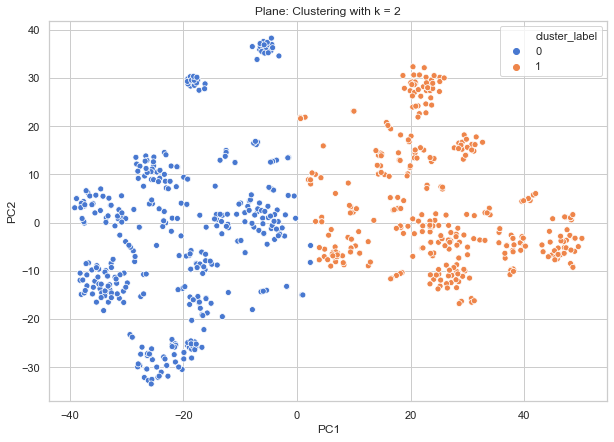

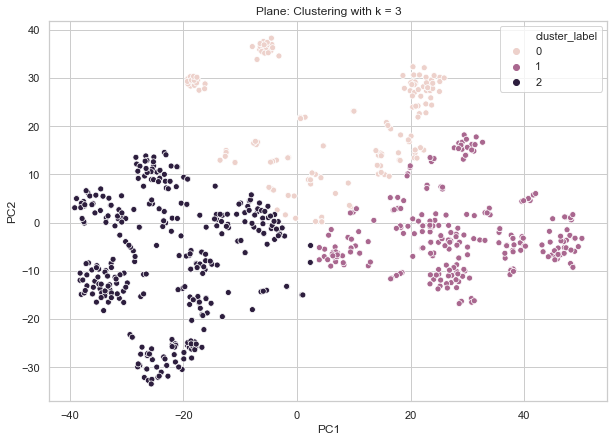

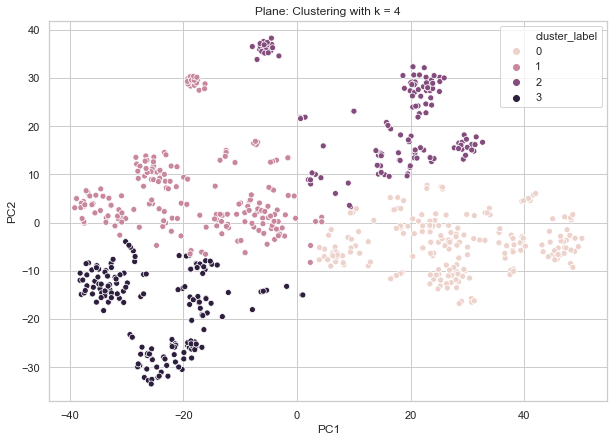

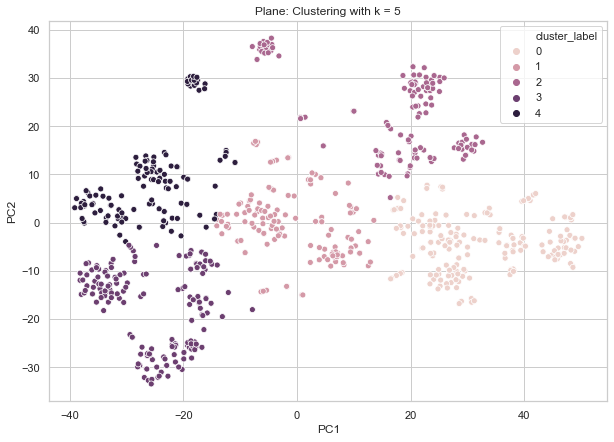

In [53]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

K = [2,3,4,5]
metrics = []

X_df = pd.DataFrame(X_embedded_tsne, columns=["PC1", "PC2"])

dfs = []
for k in K:
    metric_dict = {}

    
    kmeans = KMeans(n_clusters = k, init = "k-means++")
    labels = kmeans.fit_predict(X_df)
    
    sil_score = silhouette_score(X_df, labels)
    
    metric_dict["k"] = k
    metric_dict["silhouette_score"] = sil_score
    metrics.append(metric_dict)
    
    dfs.append(plot_clusters(labels, X_df, k))
    
metrics_df = pd.DataFrame(metrics)
metrics_df

In [59]:
df = dfs[1]

df["dish"] = list_dish_names[y_filtered].tolist()
df

,PC1,PC2,cluster_label,dish
0,-33.320862,-11.120993,3,hummus
1,-1.463815,13.483641,1,apple_pie
2,17.987509,12.966332,2,waffles
3,-3.176290,34.565750,2,dumplings
4,33.451103,1.993745,0,chocolate_cake
...,...,...,...,...
755,9.419461,-6.119137,1,strawberry_shortcake
756,-32.646404,-15.594141,3,hummus
757,28.415392,15.339793,2,apple_pie
758,-21.959877,-25.749432,3,spaghetti_carbonara
